<a href="https://colab.research.google.com/github/anuxcr/Flight-Delay-Analytics-with-PySpark-/blob/main/Flight_Delay_Analytics_with_PySpark_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Import necessary PySpark modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, when, lit
import time
import pandas as pd
import numpy as np

# 1. Initialize Spark Session
# This is the entry point to PySpark functionality.
# For a local setup, it will run Spark in local mode.
spark = SparkSession.builder \
  .appName("PySparkAirlineDelayAnalysis") \
  .config("spark.executor.memory", "4g") \
  .config("spark.driver.memory", "4g") \
  .getOrCreate()

print("Spark Session Initialized.")

# 2. Data Ingestion
file_path = "Airline_Delay_Cause.csv" # Ensure this file exists
print(f"Loading data from {file_path}...")
start_time = time.time()
try:
    # It's often better to define schema explicitly for very large files for performance,
    # but inferSchema=True is convenient for initial exploration.
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    print(f"Data loaded in {time.time() - start_time:.2f} seconds.")
    print("Initial Schema:")
    df.printSchema()
    print(f"Total records: {df.count()}") # An action that triggers computation [1]

    # 3. Data Cleaning and Preprocessing
    print("\nPerforming data cleaning...")
    start_time = time.time()

    # List of delay columns to fill missing values for
    delay_columns = ['arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

    # Fill missing numeric delay values with 0 [2]
    df_cleaned = df.fillna(0, subset=delay_columns) \
                 .dropna(subset=['airport_name', 'carrier_name']) # Drop rows with missing essential airport/carrier info [2]

    # Ensure 'arr_delay' is float (inferSchema might do this, but explicit cast is safer)
    df_cleaned = df_cleaned.withColumn("arr_delay", col("arr_delay").cast("float"))

    # Remove duplicates (if any) [2]
    df_cleaned = df_cleaned.dropDuplicates()
    print(f"Data cleaning completed in {time.time() - start_time:.2f} seconds.")

    # 4. Scalable Data Analysis - Aggregations and Insights

    # Example 1: Calculate average arrival delay by airline [2]
    print("\nCalculating average arrival delay by airline...")
    start_time = time.time()
    avg_delay_by_airline = df_cleaned.groupBy("carrier_name") \
                                   .agg(avg("arr_delay").alias("AverageArrivalDelay")) \
                                   .orderBy(col("AverageArrivalDelay").desc())
    print("Top 10 Airlines by Average Arrival Delay:")
    avg_delay_by_airline.show(10, truncate=False) # An action that triggers computation [1]
    print(f"Aggregation completed in {time.time() - start_time:.2f} seconds.")

    # Example 2: Calculate on-time arrival rate by airport [2]
    print("\nCalculating on-time arrival rate by airport...")
    start_time = time.time()
    # On-time arrival is typically arr_delay <= 0
    on_time_rate_by_airport = df_cleaned.groupBy("airport_name") \
                                      .agg(
                                            (count(when(col("arr_delay") <= 0, 1)) / count(lit(1))) \
                                          .alias("OnTimeArrivalRate")
                                        ) \
                                      .orderBy(col("OnTimeArrivalRate").desc())
    print("Top 10 Airports by On-Time Arrival Rate:")
    on_time_rate_by_airport.show(10, truncate=False) # An action that triggers computation [1]
    print(f"Aggregation completed in {time.time() - start_time:.2f} seconds.")

    # Example 3: Identify the 5 longest individual delays [2]
    print("\nIdentifying the 5 longest individual delays...")
    start_time = time.time()
    longest_delays = df_cleaned.orderBy(col("arr_delay").desc()).limit(5)
    print("Top 5 Longest Delays (Carrier, Airport, Delay Minutes):")
    longest_delays.select("carrier_name", "airport_name", "arr_delay").show(truncate=False)
    print(f"Longest delays identified in {time.time() - start_time:.2f} seconds.")

    # Example 4: Identify monthly trends in delays [2]
    print("\nCalculating average arrival delay by month...")
    start_time = time.time()
    monthly_delay = df_cleaned.groupBy("month") \
                            .agg(avg("arr_delay").alias("AverageArrivalDelay")) \
                            .orderBy("month")
    print("Average Arrival Delay by Month:")
    monthly_delay.show(truncate=False)
    print(f"Monthly trends calculated in {time.time() - start_time:.2f} seconds.")

    # 5. Demonstrating Scalability (Conceptual)
    # To truly demonstrate scalability, you would:
    # a) Run the above code with varying dataset sizes (e.g., 1M, 5M, 10M rows) and plot execution times. [3, 4]
    # b) Monitor SparkUI (usually at http://localhost:4040) to see distributed tasks, memory usage, and shuffles. [5, 6, 7]
    # c) Compare performance with a single-machine Pandas equivalent (which would likely crash or be extremely slow for large data). [8, 3]

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure 'Airline_Delay_Cause.csv' exists and is accessible, or run the synthetic data generation function.")



Spark Session Initialized.
Loading data from Airline_Delay_Cause.csv...
Data loaded in 1.75 seconds.
Initial Schema:
root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- carrier_name: string (nullable = true)
 |-- airport: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- arr_flights: double (nullable = true)
 |-- arr_del15: double (nullable = true)
 |-- carrier_ct: double (nullable = true)
 |-- weather_ct: double (nullable = true)
 |-- nas_ct: double (nullable = true)
 |-- security_ct: double (nullable = true)
 |-- late_aircraft_ct: double (nullable = true)
 |-- arr_cancelled: double (nullable = true)
 |-- arr_diverted: double (nullable = true)
 |-- arr_delay: double (nullable = true)
 |-- carrier_delay: double (nullable = true)
 |-- weather_delay: double (nullable = true)
 |-- nas_delay: double (nullable = true)
 |-- security_delay: double (nullable = true)
 |-- late_aircraft_delay: double 


Visualizing Top 10 Airlines by Average Arrival Delay...


/tmp/ipython-input-10-1956007845.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AverageArrivalDelay', y='carrier_name', data=avg_delay_by_airline_pd.head(10), palette='viridis')


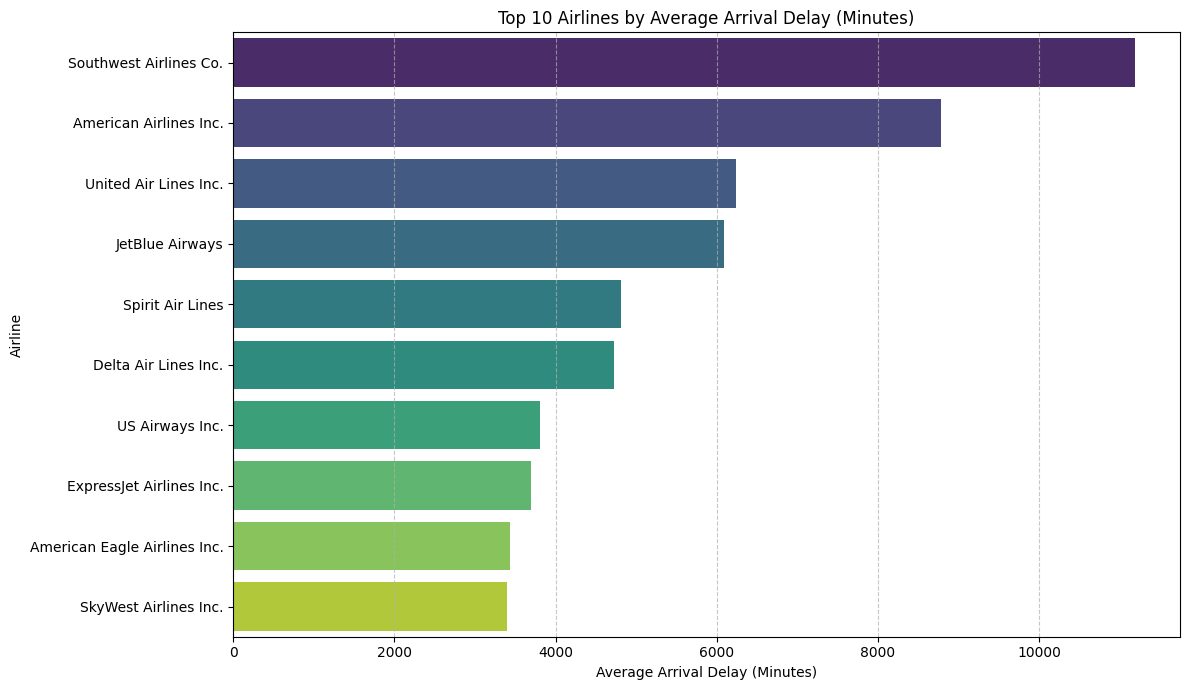


Visualizing Top 10 Airports by On-Time Arrival Rate...


/tmp/ipython-input-10-1956007845.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='OnTimeArrivalRate', y='airport_name', data=on_time_rate_by_airport_pd_sorted, palette='magma')


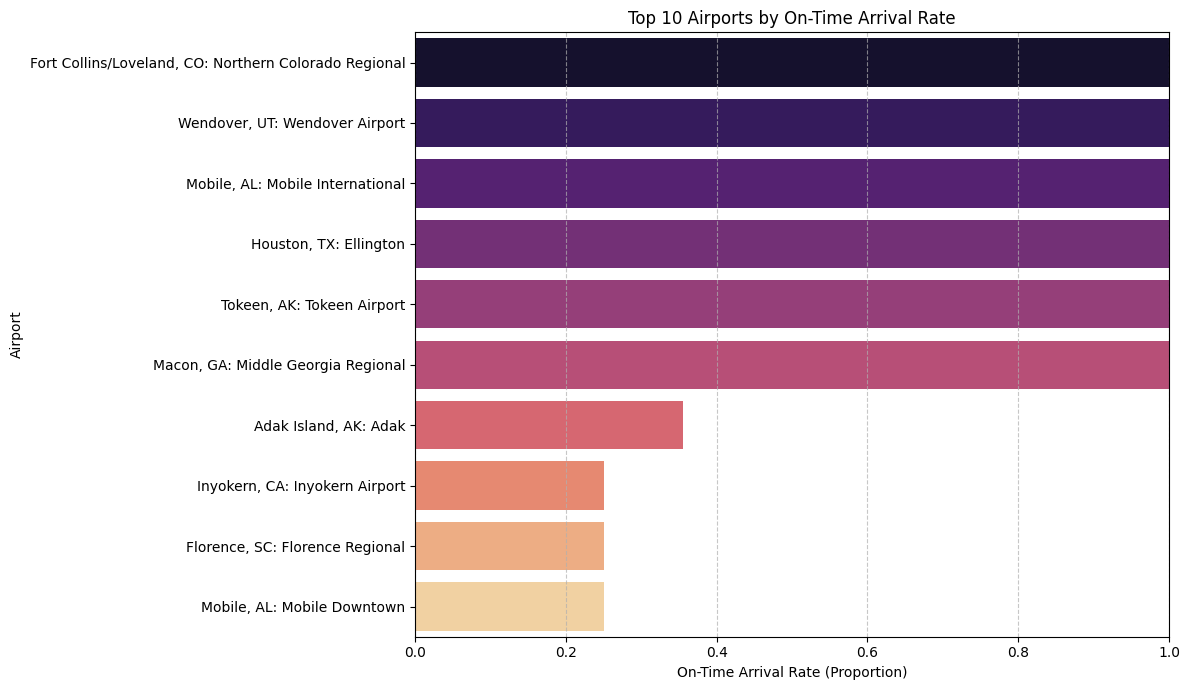


Visualizing Average Arrival Delay by Month...


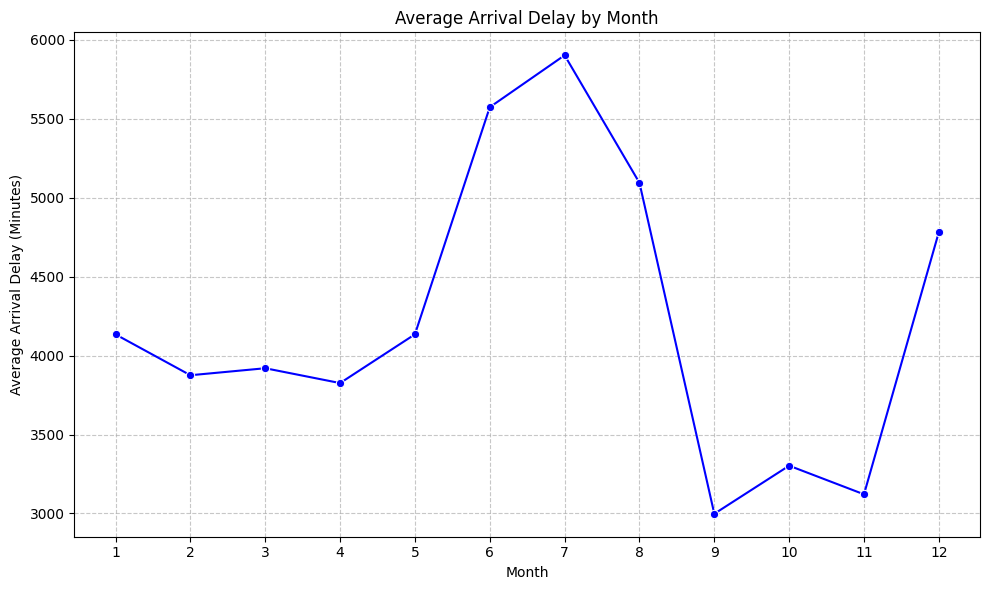


Visualizing Distribution of Top 5 Longest Delays...


/tmp/ipython-input-10-1956007845.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='arr_delay', y='carrier_name', data=longest_delays_pd.sort_values(by='arr_delay', ascending=False), palette='Reds_d')


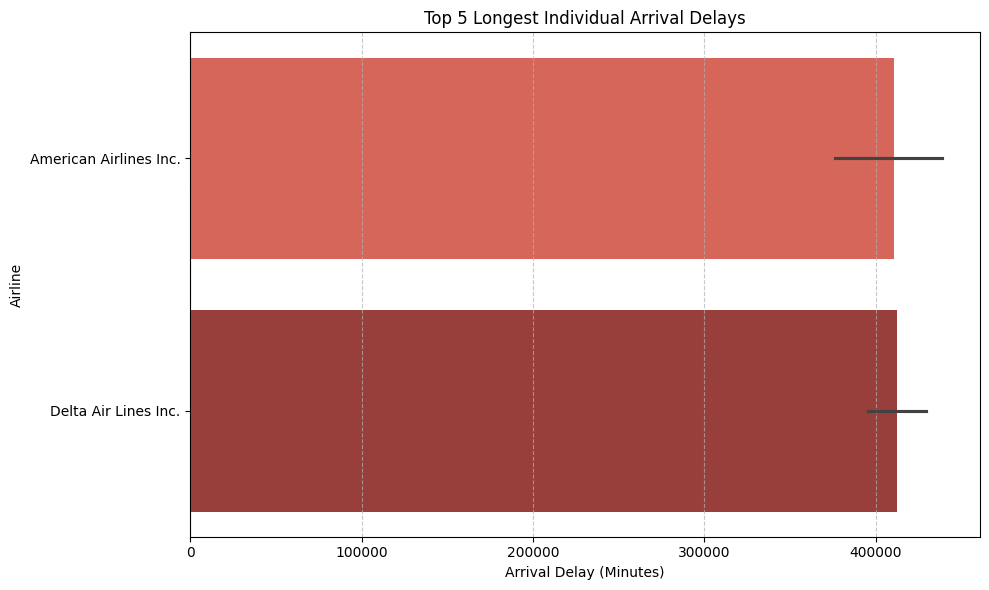


PySpark visualizations complete.
Spark Session Stopped.


In [10]:
# Import necessary plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Already imported in analysis script, but good to be explicit

# IMPORTANT: Ensure your SparkSession is still active from the analysis script.
# Do NOT call spark.stop() in the analysis script if you intend to run this visualization code separately.
# The 'spark' object should be available and active here.

# Assuming you have already run the PySpark analysis and have these DataFrames:
# avg_delay_by_airline (PySpark DataFrame)
# on_time_rate_by_airport (PySpark DataFrame)
# monthly_delay (PySpark DataFrame)
# longest_delays (PySpark DataFrame)

# --- Visualization 1: Top 10 Airlines by Average Arrival Delay ---
print("\nVisualizing Top 10 Airlines by Average Arrival Delay...")
# Convert PySpark DataFrame to Pandas DataFrame for plotting
avg_delay_by_airline_pd = avg_delay_by_airline.toPandas() # [2]

plt.figure(figsize=(12, 7))
sns.barplot(x='AverageArrivalDelay', y='carrier_name', data=avg_delay_by_airline_pd.head(10), palette='viridis')
plt.title('Top 10 Airlines by Average Arrival Delay (Minutes)')
plt.xlabel('Average Arrival Delay (Minutes)')
plt.ylabel('Airline')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualization 2: Top 10 Airports by On-Time Arrival Rate ---
print("\nVisualizing Top 10 Airports by On-Time Arrival Rate...")
# Convert PySpark DataFrame to Pandas DataFrame for plotting
on_time_rate_by_airport_pd = on_time_rate_by_airport.toPandas() # [2]

plt.figure(figsize=(12, 7))
# Sort by OnTimeArrivalRate in descending order for better visualization of "top" rates
on_time_rate_by_airport_pd_sorted = on_time_rate_by_airport_pd.sort_values(by='OnTimeArrivalRate', ascending=False).head(10)
sns.barplot(x='OnTimeArrivalRate', y='airport_name', data=on_time_rate_by_airport_pd_sorted, palette='magma')
plt.title('Top 10 Airports by On-Time Arrival Rate')
plt.xlabel('On-Time Arrival Rate (Proportion)')
plt.ylabel('Airport')
plt.xlim(0, 1) # On-time rate is a proportion between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualization 3: Average Arrival Delay by Month ---
print("\nVisualizing Average Arrival Delay by Month...")
# Convert PySpark DataFrame to Pandas DataFrame for plotting
monthly_delay_pd = monthly_delay.toPandas() # [2]

plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='AverageArrivalDelay', data=monthly_delay_pd, marker='o', color='blue')
plt.title('Average Arrival Delay by Month')
plt.xlabel('Month')
plt.ylabel('Average Arrival Delay (Minutes)')
plt.xticks(range(1, 13)) # Ensure all months are displayed [1]
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Visualization 4 (Optional): Distribution of Longest Delays ---
print("\nVisualizing Distribution of Top 5 Longest Delays...")
# The 'longest_delays' PySpark DataFrame was already limited to 5 records in the analysis.
# Convert it to Pandas for plotting.
longest_delays_pd = longest_delays.toPandas() # [2]

plt.figure(figsize=(10, 6))
sns.barplot(x='arr_delay', y='carrier_name', data=longest_delays_pd.sort_values(by='arr_delay', ascending=False), palette='Reds_d')
plt.title('Top 5 Longest Individual Arrival Delays')
plt.xlabel('Arrival Delay (Minutes)')
plt.ylabel('Airline')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nPySpark visualizations complete.")

# Stop the SparkSession AFTER all PySpark operations and visualizations are done
spark.stop()
print("Spark Session Stopped.")